# Path-dependent Options Project - Code Notebook

**Students:** *Aparna Rai, Zaid Tayeh, Kabir Ben Nefla*  
**Course:** *[ACT460H1] Stochastic Methods for Finance & Actuarial Sciences*  
**Project:** *Path-dependent Options – Asian and Barrier Calls*

This notebook contains the code for Questions 1–6 of the project.  
It implements Monte Carlo pricing, variance-reduction techniques, sensitivity
analysis with respect to model parameters, and numerical/analytic checks for
the arithmetic/geometric Asian options and the up-and-out barrier call studied
in the written report.


## Environment and helpers

In [1]:
# =============================
# Libraries
# =============================

import numpy as np
from numpy.random import default_rng
from math import exp, log, sqrt, erf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# =============================
# Global variables
# =============================

S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.4 # volatility
T = 1.0 # years
m = 252 # trading days (standard convention)
N = 200_000
seed = 28

I collect small utility functions here; they don’t run anything by themselves.

In [3]:
# =============================
# Helpers
# =============================

# Standard normal CDF
def Phi(x):
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

# Black-Scholes European call price (d1 = d+, d2 = d-)
def bs_call(S0, K, r, sigma, T):
    if (sigma <= 0) or (T <= 0):
        return max(S0 - K*exp(-r*T), 0.0)
    d1 = (log(S0/K) + (r + 0.5*sigma*sigma)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return S0*Phi(d1) - K*exp(-r*T)*Phi(d2)

# Geometric Asian call price (discrete monitoring)
def geom_asian_call_discrete(S0, K, r, sigma, T, m):
    sig_g2 = sigma**2 * ((m+1)*(2*m+1)) / (6*m*m)
    sig_g  = sqrt(sig_g2)
    q_g = r*(m-1)/(2*m) + sigma**2*(m*m - 1)/(12*m*m)
    if sig_g * sqrt(T) == 0:
        d1 = float('inf') if S0 > K*exp(-(r-q_g)*T) else -float('inf')
    else:
        d1 = (log(S0/K) + (r - q_g + 0.5*sig_g2)*T) / (sig_g*sqrt(T))
    d2 = d1 - sig_g*sqrt(T)
    return S0*exp(-q_g*T)*Phi(d1) - K*exp(-r*T)*Phi(d2)

# Mean and standard error helper
def mean_se(x):
    x = np.asarray(x, dtype=float)
    m = x.mean()
    se = x.std(ddof=1) / np.sqrt(x.size)
    return m, se

# Generate standard normal variates with optional antithetic variates to lower variance
def make_normals(N, m, seed, antithetic=True):
    rng = default_rng(seed)
    Z = rng.standard_normal((N, m))
    if antithetic:
        Z = np.concatenate([Z, -Z], axis=0)
    return Z

# Monte Carlo estimator for geometric-average Asian call using pre-generated standard normals Z_all
def mc_geom_asian_call_given_Z(Z_all, S0, K, r, sigma, T, m):
    N_eff = Z_all.shape[0]
    dt   = T / m
    sqdt = sqrt(dt)
    drift_dt = (r - 0.5*sigma*sigma) * dt

    # Evolve GBM exactly on monitoring dates and accumulate log S for the geometric mean
    S = np.full(N_eff, S0, dtype=float)
    logS_sum = np.zeros(N_eff, dtype=float)
    for i in range(m):
        Zi = Z_all[:, i]
        S *= np.exp(drift_dt + sigma * sqdt * Zi)
        logS_sum += np.log(S)
    ln_geom = logS_sum / m
    geom_avg = np.exp(ln_geom)
    payoff = np.exp(-r*T) * np.maximum(geom_avg - K, 0.0)
    return payoff

# Helper for E[bar S] used in bounds
def expected_Sbar(S0, r, T, m):
    t = np.arange(1, m+1) * (T/m)
    return (S0/m) * np.exp(r*t).sum()


# Question 1 – Pricing an arithmetic-average Asian call

### BSM

We know that the Black–Scholes model defines the stock price as a Geometric Brownian Motion (GBM).

In the Black-Scholes model, the price of call and put options struck on an asset with value $S_t$ at time $t$ with strike price $K$ is given by:

$$f^{call}(S,t) = S_t \Phi(d_+) - Ke^{-r(T-t)}\Phi(d_-) \\
f^{put}(S,t) = Ke^{-r(T-t)}\Phi(-d_-) - S_t \Phi(-d_+)$$
where
$$d_\pm = \frac{\ln(S_t/K)+ (r \pm \frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T-t}} \, .$$

### GBM

We will use the example shared in class as reference to simulate sample paths from a geometric Brownian motion (GBM) and inspect the effects of the different parameters. The GBM is defined by the following Stochastic Differential Equation (SDE)

$$ dS_t = \mu S_t dt + \sigma S_t dW_t$$

Since we wish to simulate the stock price over small time steps / intervals $\Delta t$, we use the discrete simulation formula

$$
S_{t_{k+1}}
= S_{t_k} \exp\Big( (r - \tfrac{1}{2}\sigma^2)\Delta t
  + \sigma \sqrt{\Delta t}\, Z_k \Big),
$$

where $$ Z_k \sim \mathcal{N}(0,1) $$ are i.i.d. standard normal random variables.

In [4]:
# GBM exact
def simulate_gbm_exact(S0, mu, sigma, T, m, N=25, seed=28):

    rng  = default_rng(seed)
    dt   = T / m
    time = np.linspace(0.0, T, m + 1)
    S    = np.zeros((m + 1, N), dtype=float)
    S[0, :] = S0
    drift = (mu - 0.5 * sigma**2) * dt
    vol   = sigma * sqrt(dt)
    for k in range(m):
        Z = rng.standard_normal(N)
        S[k + 1, :] = S[k, :] * np.exp(drift + vol * Z)
    return time, S

###  Q1 Parameters Set Up and Asian Call pricing function

In Question 1 we estimate the price of an arithmetic-average Asian call using the Black–Scholes model and Monte Carlo simulation. We use the parameter set

$$ S_0 = 100, K = 100, r = 0.05, σ = 0.4, T = 1 $$

The next cell defines the Monte Carlo pricer for this option.


In [5]:
def asian_arith_call_mc(S0, K, r, sigma, T, m, N, seed, batch=20_000):

# N = number of antithetic pairs (i.e. effective Monte Carlo samples).
# Each pair uses +Z and -Z and we average the two payoffs.

    rng   = default_rng(seed)
    dt    = T / m
    disc  = exp(-r * T)
    drift = (r - 0.5 * sigma * sigma) * dt
    vol   = sigma * sqrt(dt)

    EY = geom_asian_call_discrete(S0, K, r, sigma, T, m)  # discounted E[Y]

    X_chunks, Y_chunks = [], []
    done = 0
    while done < N:
        # number of antithetic pairs this batch will produce
        npairs = min(batch, N - done)
        npairs = (npairs + 1) // 2

        # states for +Z and -Z legs
        S_pos = np.full(npairs, S0, dtype=float)
        S_neg = S_pos.copy()

        # running sums over monitoring dates
        sumS_pos   = np.zeros(npairs, dtype=float)  # arithmetic sum for +Z
        sumS_neg   = np.zeros(npairs, dtype=float)  # arithmetic sum for -Z
        sumlog_pos = np.zeros(npairs, dtype=float)  # geometric sum of logs for +Z
        sumlog_neg = np.zeros(npairs, dtype=float)  # geometric sum of logs for -Z

        for _ in range(m):
            Z = rng.standard_normal(npairs)
            incr_pos = np.exp(drift + vol * Z)
            incr_neg = np.exp(drift - vol * Z)

            S_pos *= incr_pos;  sumS_pos   += S_pos;  sumlog_pos += np.log(S_pos)
            S_neg *= incr_neg;  sumS_neg   += S_neg;  sumlog_neg += np.log(S_neg)

        # average at the payoff level
        A_pos = sumS_pos / m
        A_neg = sumS_neg / m
        G_pos = np.exp(sumlog_pos / m)
        G_neg = np.exp(sumlog_neg / m)

        # pair-wise discounted payoffs
        X_pair = disc * ( np.maximum(A_pos - K, 0.0) + np.maximum(A_neg - K, 0.0) ) * 0.5
        Y_pair = disc * ( np.maximum(G_pos - K, 0.0) + np.maximum(G_neg - K, 0.0) ) * 0.5

        X_chunks.append(X_pair)
        Y_chunks.append(Y_pair)

        done += npairs

    # Concatenate and trim to exactly N
    X = np.concatenate(X_chunks)[:N]  # discounted arithmetic payoffs
    Y = np.concatenate(Y_chunks)[:N]  # discounted geometric  payoffs
    n = len(X)

    # Naive MC
    est, se = mean_se(X)                   # mean & SE use actual sample size n
    ci = (est - 1.96*se, est + 1.96*se)

    # Control variate unbiased because we averaged payoffs
    covXY = np.cov(X, Y, ddof=1)[0, 1]
    varY  = Y.var(ddof=1)
    cstar = 0.0 if varY == 0.0 else covXY / varY
    theta = X - cstar * (Y - EY)
    est_cv, se_cv = mean_se(theta)
    ci_cv = (est_cv - 1.96*se_cv, est_cv + 1.96*se_cv)

    # Diagnostics
    rho = 0.0
    stdX = X.std(ddof=1); stdY = Y.std(ddof=1)
    if stdX > 0 and stdY > 0:
        rho = covXY / (stdX * stdY)
    VR = (se / se_cv)**2 if se_cv > 0 else float('inf')  # variance-reduction factor

    return {
        "price": est, "se": se, "ci": ci,
        "cv_price": est_cv, "cv_se": se_cv, "cv_ci": ci_cv,
        "cstar": cstar, "EY_geo": EY,
        "rho": rho, "VR": VR, "n": n
    }


### Visualization

Before we move forward with computing the arithmetic average and the asian call payoffs, let us take a look at the plot of some of the sample paths

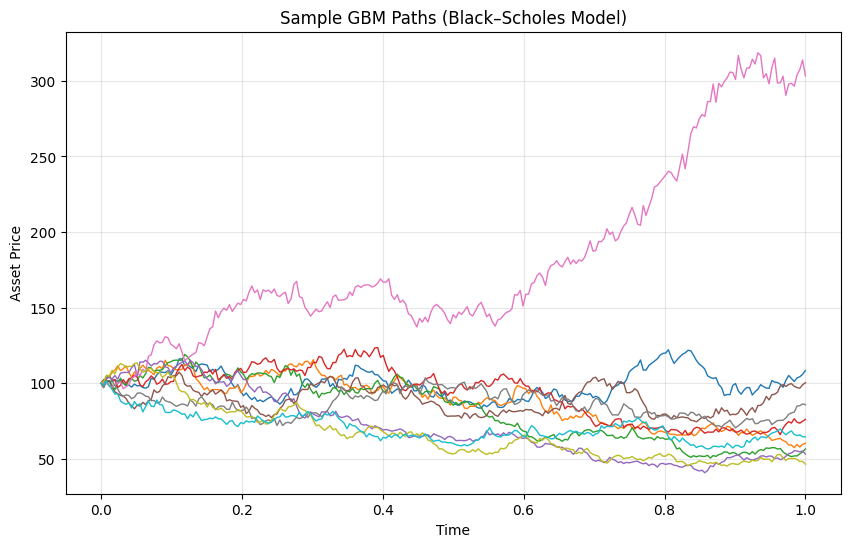

In [6]:
# Use the risk-neutral drift (mu = r) and plot on the monitoring grid m
Ndt_plot   = m
Nsims_plot = 1000
seed_plot  = seed

time, Splot = simulate_gbm_exact(S0, r, sigma, T, Ndt_plot, N=Nsims_plot, seed=seed_plot)

plt.figure(figsize=(10,6))
for i in range(min(10, Splot.shape[1])):
    plt.plot(time, Splot[:, i], linewidth=1)

plt.title("Sample GBM Paths (Black–Scholes Model)")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
# Monte Carlo estimate for Q1 parameters
res = asian_arith_call_mc(S0, K, r, sigma, T, m, N=10_000, seed=28)

print("Asian arithmetic call (naive):", res["price"])
print("Std error (naive):", res["se"])
print("95% CI (naive):", res["ci"])

print("Asian arithmetic call (control variate):", res["cv_price"])
print("Std error (CV):", res["cv_se"])
print("95% CI (CV):", res["cv_ci"])


Asian arithmetic call (naive): 10.322472804655618
Std error (naive): 0.09227319745664028
95% CI (naive): (np.float64(10.141617337640604), np.float64(10.503328271670632))
Asian arithmetic call (control variate): 10.16245070930709
Std error (CV): 0.006283742012519808
95% CI (CV): (np.float64(10.15013457496255), np.float64(10.174766843651629))


### Discounted payoff and Arithmetic Average of Each Path

Since the payoff of the Asian option is defined in terms of the average price of the underlying, not the final price, we also plot the distribution of arithmetic averages across all paths.

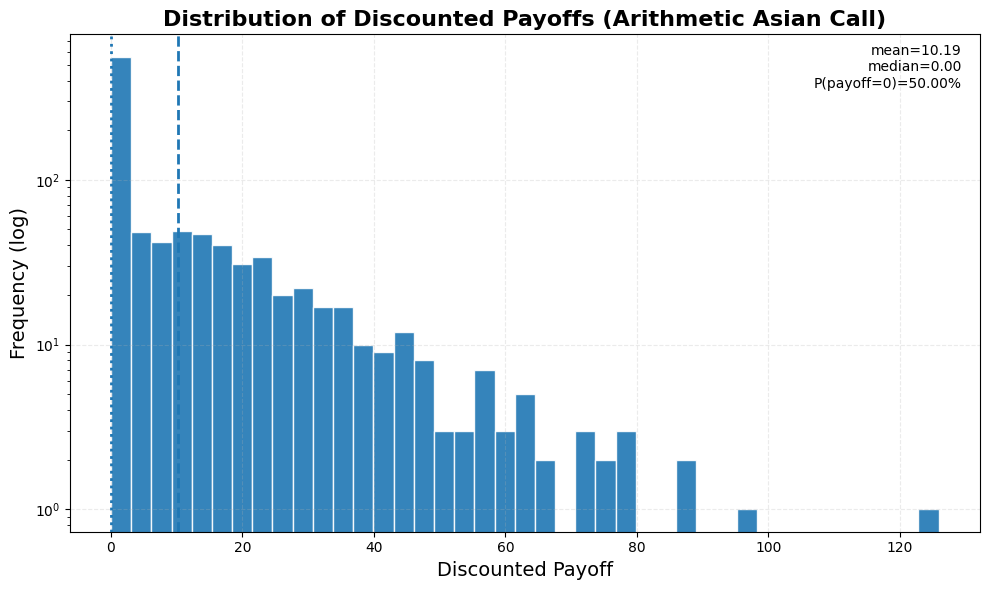

In [8]:
S_avg = Splot[1:, :].mean(axis=0)   # average over t1..tm, exclude t0

# Array of discounted payoffs
disc_payoffs = np.exp(-r*T) * np.maximum(S_avg - K, 0.0)

# Summary stats for the annotation box
mean_payoff   = float(disc_payoffs.mean())
median_payoff = float(np.median(disc_payoffs))
p_zero        = float(np.mean(disc_payoffs <= 1e-12))

plt.figure(figsize=(10,6))
plt.hist(disc_payoffs, bins="auto", edgecolor="white", alpha=0.9)
plt.title("Distribution of Discounted Payoffs (Arithmetic Asian Call)", fontsize=16, fontweight="bold")
plt.xlabel("Discounted Payoff", fontsize=14)
plt.ylabel("Frequency (log)", fontsize=14)
plt.grid(alpha=0.25, linestyle="--")

# Reference lines
plt.axvline(mean_payoff,   linestyle="--", linewidth=2)
plt.axvline(median_payoff, linestyle=":",  linewidth=2)

plt.yscale("log")

# Annotation
plt.text(0.98, 0.98,
         f"mean={mean_payoff:.2f}\nmedian={median_payoff:.2f}\nP(payoff=0)={p_zero:.2%}",
         ha="right", va="top", transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


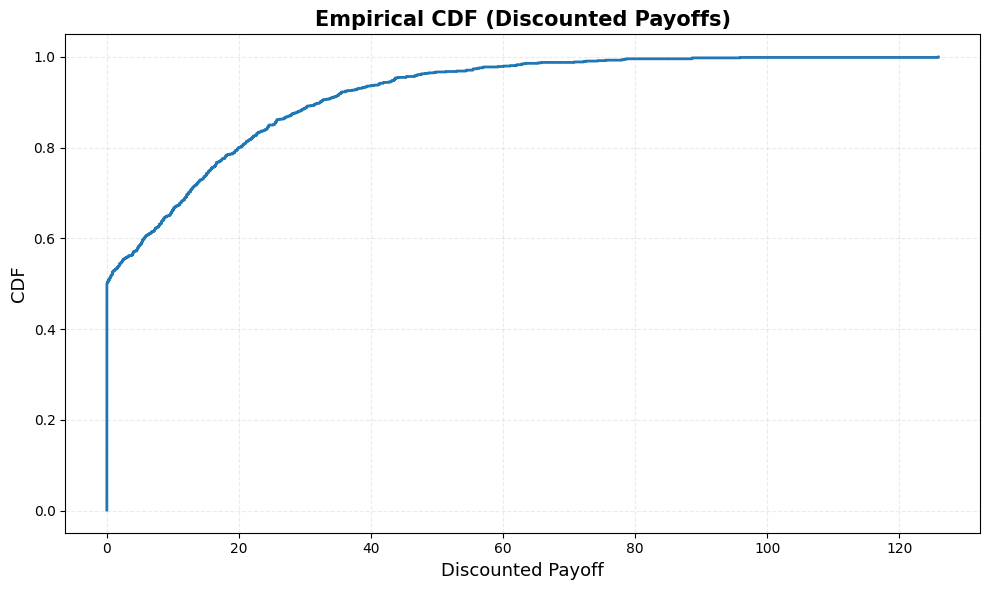

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Empirical CDF (use the same discounted array you histogrammed)
sorted_vals = np.sort(disc_payoffs)
cdf_vals = np.arange(1, sorted_vals.size + 1) / sorted_vals.size

# step plot is a nice ECDF style; use .plot if you prefer a line
ax.step(sorted_vals, cdf_vals, where="post", linewidth=2)

ax.set_title("Empirical CDF (Discounted Payoffs)", fontsize=15, fontweight="bold")
ax.set_xlabel("Discounted Payoff", fontsize=13)
ax.set_ylabel("CDF", fontsize=13)
ax.grid(alpha=0.25, linestyle="--")

plt.tight_layout()
plt.show()

### Takeaway
Even though all paths start at the same $(S_0)$, the arithmetic averages vary a lot. This spread in the path averages is what makes the Asian call payoff random and explains the width of the payoff distribution.




## Question 2 – Sensitivity to parameters

In this part we study how the Asian call price changes when we vary one parameter at a time, keeping the others at their Question 1 values. We consider:

- the initial stock price $(S_0)$,
- the strike $(K)$,
- the volatility $(\sigma)$,
- the risk-free rate $(r)$,
- the maturity $(T)$,
- and the monitoring frequency $(m)$.

For each parameter we rerun the Monte Carlo pricer and record the price with a 95% confidence interval.


### Baseline setup for Q2

We define a baseline parameter set (the same as in Q1) and specify grids of alternative values for each parameter that we will use in the sensitivity analysis.


In [10]:
# -----------------------------
# Baseline
# -----------------------------
BASE = dict(S0=100.0, K=100.0, r=0.05, sigma=0.4, T=1.0, m=252)
SEED = 28
N_SIMS = 20_000   # per grid point; CV keeps SE tiny

# -----------------------------
# Parameter grids for sweeps
# -----------------------------
GRIDS = {
    "S0":   [60, 80, 90, 100, 110, 120, 140],
    "K":    [60, 80, 90, 100, 110, 120, 140],
    "sigma":[0.10, 0.20, 0.30, 0.40, 0.60],
    "T":    [0.25, 0.50, 1.00, 2.00],
    "r":    [0.00, 0.02, 0.05, 0.10],
    "m":    [12, 52, 126, 252, 504],
}

In [11]:
def plot_sample_paths():
    Ndt_plot   = BASE["m"]
    Nsims_plot = 1000
    time, Splot = simulate_gbm_exact(BASE["S0"], BASE["r"], BASE["sigma"], BASE["T"],
                                     Ndt_plot, N=Nsims_plot, seed=SEED)
    plt.figure(figsize=(9,5.5))
    for i in range(min(10, Splot.shape[1])):
        plt.plot(time, Splot[:, i], linewidth=1)
    plt.title("Sample GBM Paths (risk-neutral)")
    plt.xlabel("Time (years)")
    plt.ylabel("Asset price")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_sweeps():
    rows = []
    for pname, values in GRIDS.items():
        for v in values:
            pars = BASE.copy()
            pars[pname] = v
            res = asian_arith_call_mc(
                S0=pars["S0"], K=pars["K"], r=pars["r"],
                sigma=pars["sigma"], T=pars["T"], m=int(pars["m"]),
                N=N_SIMS, seed=SEED
            )
            rows.append({
                "parameter": pname,
                "value": float(v),
                "cv_price": float(res["cv_price"]),
                "cv_se": float(res["cv_se"]),
                "naive_price": float(res["price"]),
                "naive_se": float(res["se"]),
                "VR": float(res["VR"])
            })
    df = pd.DataFrame(rows)


    base_res = asian_arith_call_mc(**BASE, N=N_SIMS, seed=SEED)
    baseline = dict(BASE)
    baseline.update({
        "cv_price": base_res["cv_price"],
        "cv_se": base_res["cv_se"],
        "naive_price": base_res["price"],
        "naive_se": base_res["se"],
        "VR": base_res["VR"],
        "european_call": bs_call(BASE["S0"], BASE["K"], BASE["r"], BASE["sigma"], BASE["T"]),
        "geom_asian_discrete": geom_asian_call_discrete(BASE["S0"], BASE["K"], BASE["r"], BASE["sigma"], BASE["T"], BASE["m"]),
    })

    return df, baseline



def plot_sweeps(df):
    params = list(GRIDS.keys())
    for pname in params:
        sub = df[df["parameter"] == pname].sort_values("value")
        x = sub["value"].values
        y = sub["cv_price"].values
        e = 1.96 * sub["cv_se"].values  # 95% CI

        plt.figure(figsize=(8,5))
        plt.plot(x, y, marker="o")
        plt.errorbar(x, y, yerr=e, fmt="none")
        plt.title(f"Arithmetic Asian Call Price vs {pname} (control variate)")
        plt.xlabel(pname); plt.ylabel("Price")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout(); plt.show()

def print_summary(df, baseline):
    print("=== Baseline ===")
    print(f"S0={BASE['S0']}, K={BASE['K']}, r={BASE['r']}, sigma={BASE['sigma']}, T={BASE['T']}, m={BASE['m']}")
    print(f"Arithmetic Asian (CV): {baseline['cv_price']:.4f}  ± 1.96*SE ≈ {1.96*baseline['cv_se']:.4f}  (VR≈{baseline['VR']:.1f}x)")
    print(f"European call (BS):    {baseline['european_call']:.4f}")
    print(f"Geometric Asian (disc):{baseline['geom_asian_discrete']:.4f}")
    print()

    def sweep_lines(pname):
        sub = df[df["parameter"] == pname].sort_values("value")
        print(f"{pname} sweep (value -> price ± 95% CI):")
        for _, row in sub.iterrows():
            lo = row["cv_price"] - 1.96*row["cv_se"]
            hi = row["cv_price"] + 1.96*row["cv_se"]
            print(f"  {row['value']:<8.4g} -> {row['cv_price']:.4f}  [{lo:.4f}, {hi:.4f}]")
        print()

    for pname in ["S0","K","sigma","T","r","m"]:
        sweep_lines(pname)

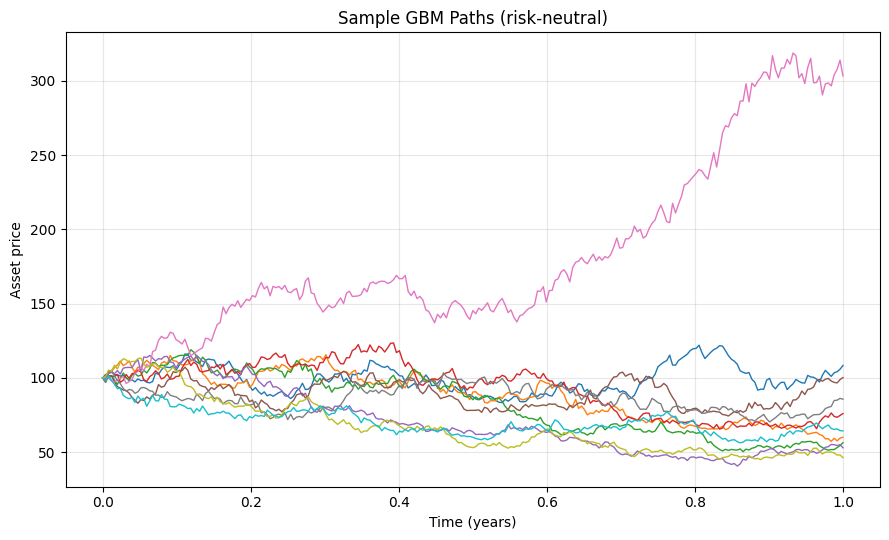

=== Baseline ===
S0=100.0, K=100.0, r=0.05, sigma=0.4, T=1.0, m=252
Arithmetic Asian (CV): 10.1589  ± 1.96*SE ≈ 0.0088  (VR≈211.5x)
European call (BS):    18.0230
Geometric Asian (disc):9.3965

S0 sweep (value -> price ± 95% CI):
  60       -> 0.1541  [0.1505, 0.1576]
  80       -> 2.2949  [2.2888, 2.3011]
  90       -> 5.3588  [5.3514, 5.3661]
  100      -> 10.1589  [10.1502, 10.1677]
  110      -> 16.5796  [16.5686, 16.5905]
  120      -> 24.2837  [24.2710, 24.2964]
  140      -> 42.0043  [41.9880, 42.0206]

K sweep (value -> price ± 95% CI):
  60       -> 40.5033  [40.4908, 40.5158]
  80       -> 22.7930  [22.7821, 22.8038]
  90       -> 15.6423  [15.6323, 15.6524]
  100      -> 10.1589  [10.1502, 10.1677]
  110      -> 6.2949  [6.2867, 6.3031]
  120      -> 3.7565  [3.7487, 3.7643]
  140      -> 1.2362  [1.2290, 1.2433]

sigma sweep (value -> price ± 95% CI):
  0.1      -> 3.6531  [3.6525, 3.6537]
  0.2      -> 5.7791  [5.7768, 5.7813]
  0.3      -> 7.9649  [7.9600, 7.9697]
  0.4  

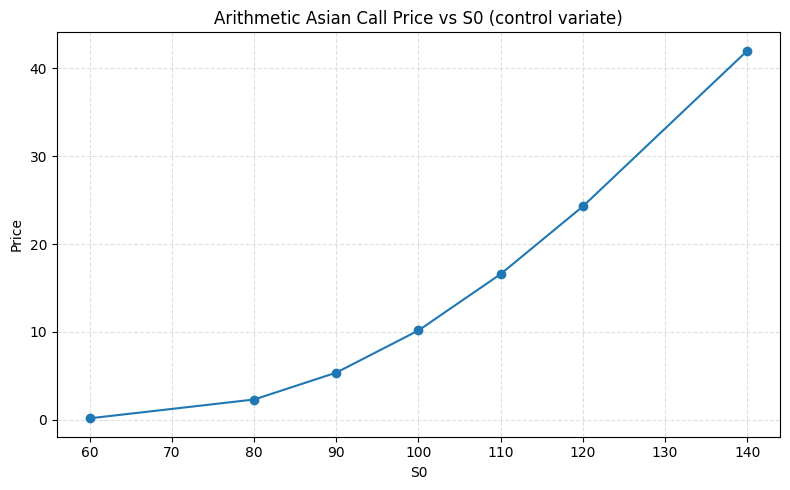

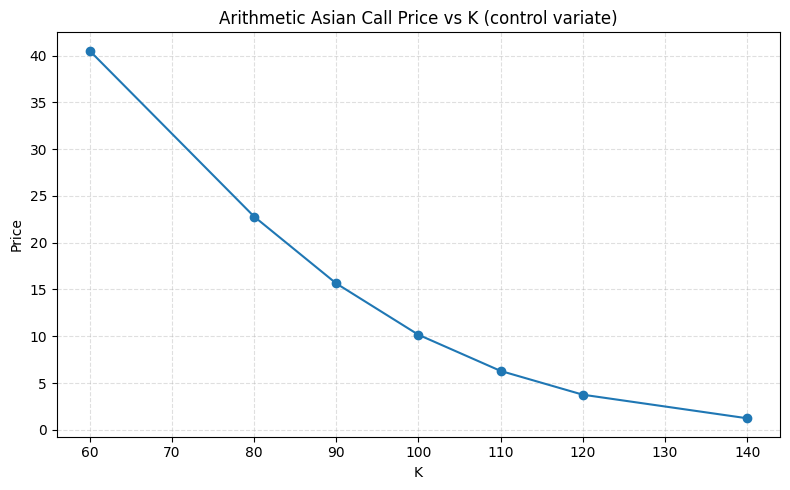

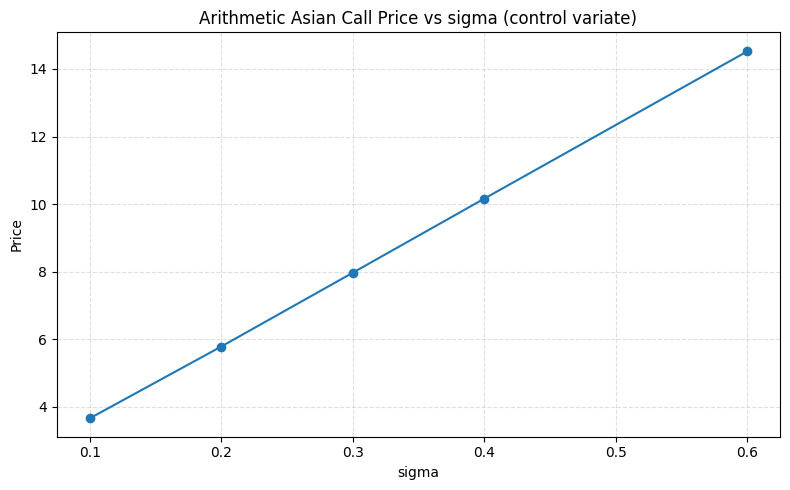

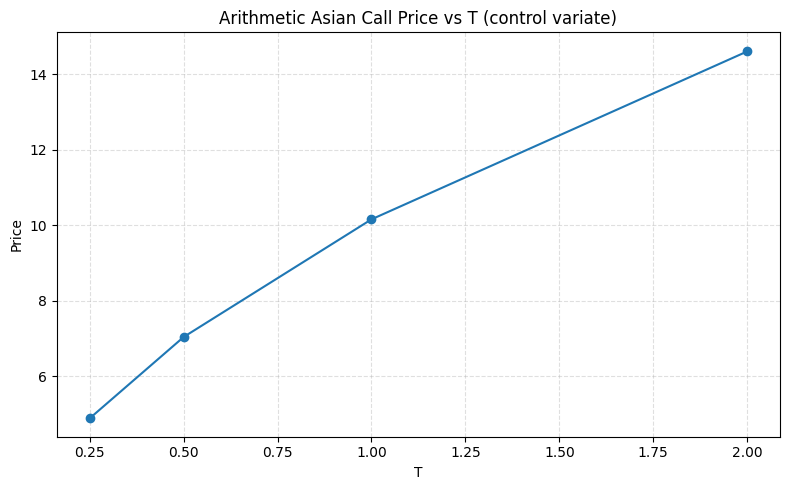

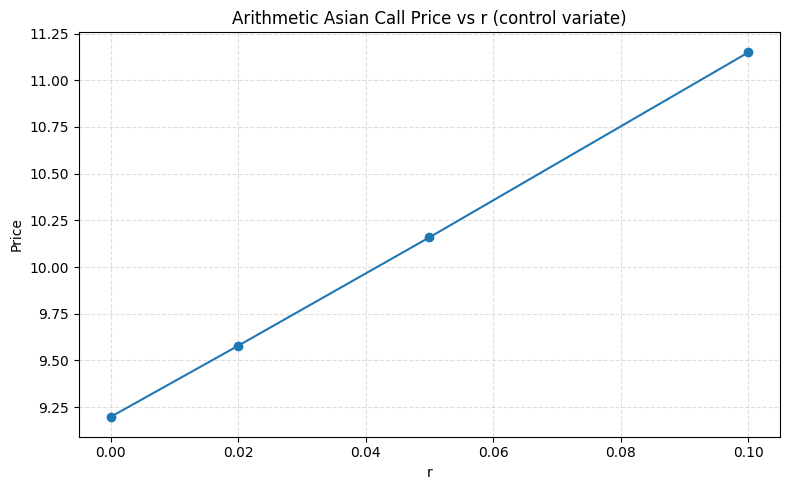

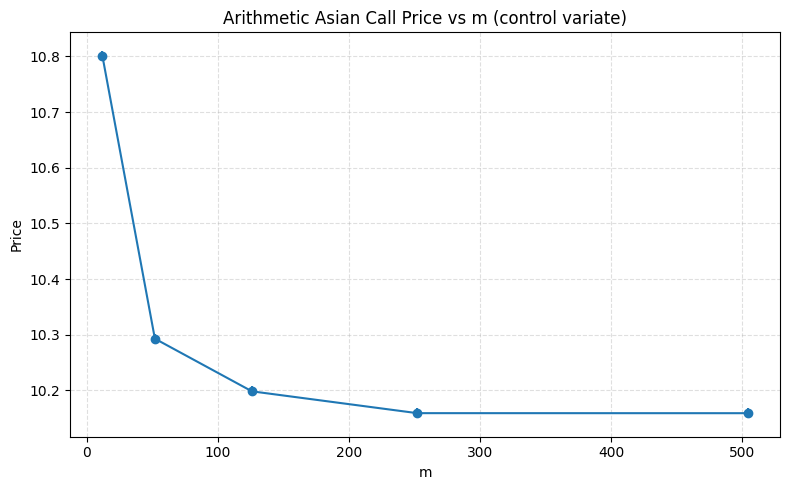

In [12]:
plot_sample_paths()
df, baseline = run_sweeps()
print_summary(df, baseline)
plot_sweeps(df)


### Takeaway
### Takeaway

The Asian call price increases with the initial stock price $S_0$, the volatility $\sigma$, the interest rate $r$, and the maturity $T$, and decreases with the strike $K$. It also decreases slightly as the monitoring frequency $m$ increases, because more frequent averaging pulls the payoff closer to the underlying’s mean path and reduces upside relative to a European call.


# Question 3 - Discretization schemes and time-step error

In this question I study how the time discretization of the GBM affects the price of the arithmetic-average Asian call. Starting from the same Black-Scholes dynamics as in Question 1, I implement three numerical schemes for the stock path:

- Euler,
- Milstein,
- second-order Itô-Taylor scheme,

and I also include the exact GBM update as a reference (no discretization error).

For a fixed number of monitoring dates $(N_{steps})$ and a large number of paths $(M)$, I compute the Asian call price under each scheme and compare it with the price obtained using the exact GBM step. I use common random numbers so that differences between schemes are due to discretization error rather than Monte Carlo noise. The aim is to see how large the bias is for a given $(N)$, and to check that the higher-order scheme gets closer to the exact result while the remaining discrepancy is mostly Monte Carlo sampling error.


In [13]:
# Question 3 – Discretization schemes for GBM (Euler, Milstein, 2nd-order, Exact)

def simulate_paths_q3(M, N_steps, scheme="exact", rng=None):

    if rng is None:
        rng = default_rng()

    dt = T / N_steps
    sqdt = np.sqrt(dt)

    # Brownian increments
    dW_all = rng.normal(loc=0.0, scale=sqdt, size=(M, N_steps))

    S = np.empty((M, N_steps + 1), dtype=float)
    S[:, 0] = S0

    if scheme == "exact":
        # Exact GBM step:
        drift = (r - 0.5 * sigma**2) * dt
        for i in range(N_steps):
            S[:, i + 1] = S[:, i] * np.exp(drift + sigma * dW_all[:, i])

    elif scheme == "euler":
        # Euler scheme
        for i in range(N_steps):
            dW = dW_all[:, i]
            S[:, i + 1] = (
                S[:, i]
                + r * S[:, i] * dt
                + sigma * S[:, i] * dW
            )

    elif scheme == "milstein":
        # Milstein scheme
        for i in range(N_steps):
            dW = dW_all[:, i]
            S[:, i + 1] = (
                S[:, i]
                + r * S[:, i] * dt
                + sigma * S[:, i] * dW
                + 0.5 * sigma**2 * S[:, i] * (dW**2 - dt)
            )

    elif scheme == "taylor2":
        # Second-order Itô–Taylor scheme specialized to GBM:
        for i in range(N_steps):
            dW = dW_all[:, i]
            S_curr = S[:, i]
            S[:, i + 1] = S_curr * (
                1.0
                + r * dt
                + sigma * dW
                + 0.5 * sigma**2 * (dW**2 - dt)
                + 0.5 * r**2 * dt**2
                + r * sigma * dW * dt
            )

    else:
        raise ValueError(f"Unknown scheme: {scheme}")

    return S

# Estimate the price of the arithmetic Asian call for a given GBM scheme.

def asian_call_price_q3(M, N_steps, scheme="exact", rng=None):

    S = simulate_paths_q3(M, N_steps, scheme=scheme, rng=rng)

    avg = S[:, 1:].mean(axis=1)

    payoff = np.maximum(avg - K, 0.0)
    disc = np.exp(-r * T)
    price = disc * payoff.mean()
    stderr = disc * payoff.std(ddof=1) / np.sqrt(M)

    return price, stderr


In [14]:
# Compare discretization schemes for the Asian call price:
# Euler, Milstein, second-order Itô–Taylor, and exact GBM.
def compare_q3_schemes(M=100_000, N_steps=50, seed=28):

    schemes = ["euler", "milstein", "taylor2", "exact"]

    # First get the "exact" reference using the same seed
    rng_exact = default_rng(seed)
    exact_price, exact_se = asian_call_price_q3(M, N_steps, scheme="exact", rng=rng_exact)

    rows = []
    for scheme in schemes:
        rng_scheme = default_rng(seed)
        price, se = asian_call_price_q3(M, N_steps, scheme=scheme, rng=rng_scheme)
        rows.append(
            {
                "scheme": scheme,
                "price": price,
                "stderr": se,
                "bias_vs_exact": price - exact_price,
            }
        )

    df = pd.DataFrame(rows).set_index("scheme")
    print(f"Q3 comparison (M={M}, N_steps={N_steps}, seed={seed})")
    print(df)
    return df



df_q3 = compare_q3_schemes(M=100_000, N_steps=50, seed=28)


Q3 comparison (M=100000, N_steps=50, seed=28)
              price    stderr  bias_vs_exact
scheme                                      
euler     10.283273  0.052347       0.003237
milstein  10.270711  0.052649      -0.009325
taylor2   10.280333  0.052709       0.000296
exact     10.280037  0.052710       0.000000


### Takeaway

For this number of time steps $(N_{steps} = 50)$, discretization error is much smaller than the Monte Carlo sampling error for all schemes.
 Euler and Milstein show small positive/negative biases relative to the exact GBM step, while the second–order scheme matches the exact price almost perfectly. This is consistent with the theory: higher–order schemes reduce the bias for a fixed time step, and in this setting the remaining discrepancy is dominated by Monte Carlo noise rather than by the time discretization itself.


# Question 4 - Greeks of the Asian call

In this section we estimate three Greeks of the arithmetic-average Asian call:
- the delta (sensitivity to $(S_0)$),
- the vega (sensitivity to $(\sigma)$),
- the rho (sensitivity to $(r)$).

We use two approaches:
1. pathwise derivative estimators, and  
2. finite differences with common random numbers.

We then compare the estimates and their standard errors for the parameter values from Question 1.


### Plotting helpers for Question 4

Below we define a few helper functions that only produce plots:

- `plot_pw_vs_fd_greeks_split`: compares pathwise vs finite-difference Greeks (one subplot per Greek),
- `plot_fd_bump_zscores`: shows z-scores of (FD - PW) for different bump sizes,
- `plot_se_convergence`: shows how the standard error shrinks as we increase the number of paths $(N)$,
- `plot_monitoring_frequency`: shows how the Asian price changes with the monitoring frequency $(m)$.


In [15]:
# =============================
# Plots
# =============================
def plot_pw_vs_fd_greeks_split(Z_all, S0, K, r, sigma, T, m,
                               eps_delta=1e-3, h_vega=1e-3, h_rho=1e-3, title_suffix=""):
    payoff, d_pw, v_pw, r_pw, _ = simulate_pw_given_Z(Z_all, S0, K, r, sigma, T, m)
    dlt_pw, se_dlt_pw = mean_se(d_pw)
    veg_pw, se_veg_pw = mean_se(v_pw)
    rho_pw, se_rho_pw = mean_se(r_pw)

    (d_fd, se_dfd), (v_fd, se_vfd), (r_fd, se_rfd) = finite_difference_greeks_crn(
        Z_all, S0, K, r, sigma, T, m,
        eps_delta=eps_delta, h_vega=h_vega, h_rho=h_rho
    )

    fig, axes = plt.subplots(1, 3, figsize=(11, 4), sharex=False)
    items = [
        ("Delta", dlt_pw, 1.96*se_dlt_pw, d_fd, 1.96*se_dfd),
        ("Vega",  veg_pw, 1.96*se_veg_pw, v_fd, 1.96*se_vfd),
        ("Rho",   rho_pw, 1.96*se_rho_pw, r_fd, 1.96*se_rfd),
    ]
    for ax, (name, pw, pw_ci, fd, fd_ci) in zip(axes, items):
        ax.bar(["PW", "FD"], [pw, fd], yerr=[pw_ci, fd_ci], capsize=3)
        ax.set_title(name)
        ax.set_ylabel("Estimate")
        ax.grid(True, alpha=0.3)
    fig.suptitle(f"Greeks (m={m}, N={Z_all.shape[0]} incl. antithetics){(' — '+title_suffix) if title_suffix else ''}")
    fig.tight_layout(rect=[0,0,1,0.95])
    plt.show()

def plot_fd_bump_zscores(Z_all, S0, K, r, sigma, T, m, bump_grid=(5e-4, 1e-3, 2e-3, 5e-3)):
    # PW reference
    _, d_pw, v_pw, r_pw, _ = simulate_pw_given_Z(Z_all, S0, K, r, sigma, T, m)
    dlt_pw, se_dlt_pw = mean_se(d_pw)
    veg_pw, se_veg_pw = mean_se(v_pw)
    rho_pw, se_rho_pw = mean_se(r_pw)

    def _zs(mu_fd, se_fd, mu_pw, se_pw):
        den = np.sqrt(se_fd**2 + se_pw**2)
        return (mu_fd - mu_pw) / den

    z_d, z_v, z_r = [], [], []
    for b in bump_grid:
        (d_fd, se_dfd), (v_fd, se_vfd), (r_fd, se_rfd) = finite_difference_greeks_crn(
            Z_all, S0, K, r, sigma, T, m, eps_delta=b, h_vega=b, h_rho=b
        )
        z_d.append(_zs(d_fd, se_dfd, dlt_pw, se_dlt_pw))
        z_v.append(_zs(v_fd, se_vfd, veg_pw, se_veg_pw))
        z_r.append(_zs(r_fd, se_rfd, rho_pw, se_rho_pw))

    fig, ax = plt.subplots(figsize=(7,4))
    ax.semilogx(bump_grid, z_d, "o-", label="Delta")
    ax.semilogx(bump_grid, z_v, "o-", label="Vega")
    ax.semilogx(bump_grid, z_r, "o-", label="Rho")
    ax.axhline(0, color="k", linewidth=1)
    ax.axhline(1.96, linestyle="--", linewidth=1)
    ax.axhline(-1.96, linestyle="--", linewidth=1)
    ax.set_xlabel("Bump size (log scale)")
    ax.set_ylabel("z-score (FD − PW)")
    ax.set_title("FD vs PW: z-score across bump sizes (|z|≲1.96 ⇒ agree at 95%)")
    ax.grid(True, which="both", alpha=0.3)
    ax.legend()
    plt.show()

def plot_se_convergence(S0, K, r, sigma, T, m, Ns=(25_000, 50_000, 100_000, 200_000), seed=28):
    se_price_list, se_d_list, se_v_list, se_r_list = [], [], [], []
    for idx, N in enumerate(Ns):
        Z_all = make_normals(N, m, seed=seed+idx, antithetic=True)
        payoff, d_pw, v_pw, r_pw, _ = simulate_pw_given_Z(Z_all, S0, K, r, sigma, T, m)
        _, se_price = mean_se(payoff)
        _, se_d     = mean_se(d_pw)
        _, se_v     = mean_se(v_pw)
        _, se_r     = mean_se(r_pw)
        se_price_list.append(se_price); se_d_list.append(se_d)
        se_v_list.append(se_v); se_r_list.append(se_r)

    Ns = np.array(Ns, dtype=float)
    fig, ax = plt.subplots(figsize=(7,4))
    ax.loglog(Ns, se_price_list, "o-", label="Price s.e.")
    ax.loglog(Ns, se_d_list, "o-", label="Delta s.e.")
    ax.loglog(Ns, se_v_list, "o-", label="Vega s.e.")
    ax.loglog(Ns, se_r_list, "o-", label="Rho s.e.")
    ref = se_price_list[0] * np.sqrt(Ns[0] / Ns)   # ~ 1/sqrt(N)
    ax.loglog(Ns, ref, "--", label="Reference ~ 1/√N")
    ax.set_xlabel("Number of base paths N (log)")
    ax.set_ylabel("Standard error (log)")
    ax.set_title("Convergence: standard error vs N")
    ax.grid(True, which="both", alpha=0.3)
    ax.legend()
    plt.show()

def plot_monitoring_frequency(S0, K, r, sigma, T, m_list=(12, 52, 252), N=60_000, seed=2025):
    prices, errs = [], []
    for j, m in enumerate(m_list):
        Z_all = make_normals(N, m, seed=seed+j, antithetic=True)
        payoff, *_ = simulate_pw_given_Z(Z_all, S0, K, r, sigma, T, m)
        p, se = mean_se(payoff)
        prices.append(p); errs.append(1.96*se)

    fig, ax = plt.subplots(figsize=(7,4))
    ax.errorbar(m_list, prices, yerr=errs, fmt="o-", capsize=3)
    ax.set_xlabel("Monitoring frequency m")
    ax.set_ylabel("Asian call price (±95% CI)")
    ax.set_title("Monitoring-frequency effect (price should ↓ as m ↑)")
    ax.grid(True, alpha=0.3)
    plt.show()


### Monte Carlo engine

The next cell contains the core simulation routines:

- `make_normals`: generates the Gaussian draws (with optional antithetics),
- `simulate_pw_given_Z`: simulates GBM on the monitoring dates and returns the discounted payoff and pathwise Delta/Vega/Rho,
- `expected_Sbar`: computes $(E[\bar S])$, which we use when forming bounds.

Most of the later analysis relies on these functions.


In [16]:
# =============================
# Core simulation (pathwise)
# =============================

# Simulate on monitoring dates using exact GBM steps.
# Returns payoff & pathwise Greeks arrays,
# plus optional moment checks at selected indices

def simulate_pw_given_Z(Z_all, S0, K, r, sigma, T, m, track_idx=None):
    N_eff = Z_all.shape[0]
    dt = T / m
    sqdt = np.sqrt(dt)
    drift_dt = (r - 0.5*sigma**2) * dt

    # State variables and accumulators
    S  = np.full(N_eff, S0, dtype=float) # asset price
    W  = np.zeros(N_eff, dtype=float) # Brownian motion
    sumS = np.zeros(N_eff, dtype=float) # sum of asset prices (for average)
    sumS_t = np.zeros(N_eff, dtype=float) # sum of t * asset prices (for rho)
    sumS_W_minus_sig_t = np.zeros(N_eff, dtype=float) # sum of S * (W - sigma * t) (for vega)

    # Optional stats containers at selected time steps
    # to check mean/var of GBM marginals, log-returns, W_t
    track_idx = sorted(set(track_idx or []))
    stats = {i: {"sum_S":0.0, "sum_S2":0.0,
                 "sum_logR":0.0, "sum_logR2":0.0,
                 "sum_W":0.0, "sum_W2":0.0} for i in track_idx}

    # Time-stepping loop over monitoring dates:
        # 1. Grab the i-th standard normal variates for all paths
        # 2. Update W and S
        # 3. Update accumulators for averages and Greeks
    for i in range(1, m+1):
        Zi = Z_all[:, i-1]
        W += sqdt * Zi
        S *= np.exp(drift_dt + sigma * sqdt * Zi)
        t = i * dt
        sumS += S
        sumS_t += t * S
        sumS_W_minus_sig_t += S * (W - sigma * t)

        # Collect stats if requested
        if i in stats:
            s = S
            lr = np.log(S / S0)
            w = W
            stats[i]["sum_S"]   += s.sum()
            stats[i]["sum_S2"]  += (s*s).sum()
            stats[i]["sum_logR"] += lr.sum()
            stats[i]["sum_logR2"]+= (lr*lr).sum()
            stats[i]["sum_W"]   += w.sum()
            stats[i]["sum_W2"]  += (w*w).sum()

    # Compute arithmetic average and payoff using
    # indicator to check whether the payoff is in-the-money
    # and if so, compute discounted payoff
    Sbar = sumS / m
    I = (Sbar > K).astype(float)
    disc = np.exp(-r * T)
    payoff = disc * np.maximum(Sbar - K, 0.0)

    # Compute pathwise Greeks
    delta_pw = disc * I * (Sbar / S0)
    vega_pw  = disc * I * (sumS_W_minus_sig_t / m)
    rho_pw   = disc * (-T * np.maximum(Sbar - K, 0.0) + I * (sumS_t / m))

    # Finalize stats to means/vars
    out_stats = {}
    if stats:
        n = float(N_eff)
        for i, d in stats.items():
            mean_S   = d["sum_S"]/n
            var_S    = d["sum_S2"]/n - mean_S**2
            mean_lr  = d["sum_logR"]/n
            var_lr   = d["sum_logR2"]/n - mean_lr**2
            mean_W   = d["sum_W"]/n
            var_W    = d["sum_W2"]/n - mean_W**2
            out_stats[i] = dict(mean_S=mean_S, var_S=var_S,
                                mean_logR=mean_lr, var_logR=var_lr,
                                mean_W=mean_W, var_W=var_W)
    return payoff, delta_pw, vega_pw, rho_pw, out_stats


### Finite-difference Greeks with common random numbers

Here we implement central finite-difference estimators for the Greeks, using common random numbers:

- `simulate_payoff_only_given_Z`: payoff-only simulation for a fixed matrix of normals,
- `finite_difference_greeks_crn`: returns delta, vega, and rho (and their standard errors) for a given bump size.

Later we compare these FD Greeks to the pathwise estimators.


In [17]:
# =============================
# Finite-difference Greeks (CRN)
# =============================

# Simulate only the payoff given pre-generated normals Z_all
# W isn’t needed here, so we don’t track it
def simulate_payoff_only_given_Z(Z_all, S0, K, r, sigma, T, m):
    N_eff = Z_all.shape[0]
    dt = T / m
    sqdt = np.sqrt(dt)
    drift_dt = (r - 0.5*sigma**2) * dt

    S  = np.full(N_eff, S0, dtype=float)
    W  = 0.0  # not needed for payoff only
    sumS = np.zeros(N_eff, dtype=float)

    # Exact GBM stepping loop and accumulators for average
    for i in range(1, m+1):
        Zi = Z_all[:, i-1]
        S *= np.exp(drift_dt + sigma * sqdt * Zi)
        sumS += S

    Sbar = sumS / m
    disc = np.exp(-r * T)
    return disc * np.maximum(Sbar - K, 0.0)

# Finite-difference Greeks with common random numbers (CRN) approach
def finite_difference_greeks_crn(Z_all, S0, K, r, sigma, T, m,
                                 eps_delta=1e-3, h_vega=1e-3, h_rho=1e-3):
    # Delta
    p_plus  = simulate_payoff_only_given_Z(Z_all, S0*(1+eps_delta), K, r, sigma, T, m)
    p_minus = simulate_payoff_only_given_Z(Z_all, S0*(1-eps_delta), K, r, sigma, T, m)
    delta_paths = (p_plus - p_minus) / (2*S0*eps_delta)

    # Vega
    p_plus  = simulate_payoff_only_given_Z(Z_all, S0, K, r, sigma + h_vega, T, m)
    p_minus = simulate_payoff_only_given_Z(Z_all, S0, K, r, sigma - h_vega, T, m)
    vega_paths = (p_plus - p_minus) / (2*h_vega)

    # Rho
    p_plus  = simulate_payoff_only_given_Z(Z_all, S0, K, r + h_rho, sigma, T, m)
    p_minus = simulate_payoff_only_given_Z(Z_all, S0, K, r - h_rho, sigma, T, m)
    rho_paths = (p_plus - p_minus) / (2*h_rho)

    dlt, se_dlt = mean_se(delta_paths)
    veg, se_veg = mean_se(vega_paths)
    rho, se_rho = mean_se(rho_paths)
    return (dlt, se_dlt), (veg, se_veg), (rho, se_rho)

### Summary cell for Question 4

In the folowing, we run some checks for the Asian option and its Greeks. It:
- runs the simulation and reports the Asian price and pathwise Greeks with 95% confidence intervals,
- prints bounds and comparators (Jensen, trivial, geometric-Asian closed form, and the European call),
- computes finite-difference Greeks for several bump sizes and compares them to the pathwise estimates,
- checks convergence by comparing standard errors at $(N)$ and $(2N)$,
- illustrates the monitoring-frequency effect,
- and performs simple sign checks on the Greeks.


In [18]:
# =============================
# Sanity & quality checks runner
# =============================

# Run a suite of checks on the Asian option simulation and Greeks
def run_checks(S0=100.0, K=100.0, r=0.05, sigma=0.4, T=1.0, m=252, N=100_000, seed=28):

    # Baseline simulation with pathwise Greeks
    print("=== Baseline simulation (pathwise) ===")
    Z_all = make_normals(N, m, seed=seed, antithetic=True)
    payoff, d_pw, v_pw, r_pw, stats = simulate_pw_given_Z(
        Z_all, S0, K, r, sigma, T, m, track_idx=[m//4, m//2, m])

    # Compute means and standard errors
    price, se_price = mean_se(payoff)
    dlt, se_dlt = mean_se(d_pw)
    veg, se_veg = mean_se(v_pw)
    rho, se_rho = mean_se(r_pw)

    # Print results
    print(f"Asian (arith) price: {price:.4f}  ± {1.96*se_price:.4f} (95% CI half-width)")
    print(f"Delta  (PW):         {dlt:.4f}  ± {1.96*se_dlt:.4f}")
    print(f"Vega   (PW):         {veg:.4f}  ± {1.96*se_veg:.4f}")
    print(f"Rho    (PW):         {rho:.4f}  ± {1.96*se_rho:.4f}")

    # Additional checks
    print("\n=== Bounds & comparators ===")
    EbarS = expected_Sbar(S0, r, T, m)
    jensen_lb = exp(-r*T) * max(EbarS - K, 0.0)
    trivial_ub = exp(-r*T) * EbarS
    c_geom = geom_asian_call_discrete(S0, K, r, sigma, T, m)
    c_euro = bs_call(S0, K, r, sigma, T)

    # Print bounds and comparators
    print(f"E[bar S]             = {EbarS:.4f}")
    print(f"Jensen lower bound   = {jensen_lb:.4f}")
    print(f"Trivial upper bound  = {trivial_ub:.4f}")
    print(f"Geom-Asian (closed)  = {c_geom:.4f}")
    print(f"European call (BS)   = {c_euro:.4f}")
    print(f"Check: Geom ≤ Arith ≤ Euro?  {c_geom <= price <= c_euro}")

    # Finite-difference Greeks with CRN and comparison to pathwise
    print("\n=== Finite-difference Greeks (CRN) vs Pathwise ===")
    for (eps_delta, h_vega, h_rho) in [(5e-4, 5e-4, 5e-4), (1e-3, 1e-3, 1e-3), (5e-3, 5e-3, 5e-3)]:
        (d_fd, se_dfd), (v_fd, se_vfd), (r_fd, se_rfd) = finite_difference_greeks_crn(
            Z_all, S0, K, r, sigma, T, m, eps_delta, h_vega, h_rho
        )
        print(f"  bumps (Δ:{eps_delta:g}, V:{h_vega:g}, ρ:{h_rho:g}) "
              f"=> Δ {d_fd:.4f}±{1.96*se_dfd:.4f} | V {v_fd:.4f}±{1.96*se_vfd:.4f} | ρ {r_fd:.4f}±{1.96*se_rfd:.4f}")
    print("Compare each FD with PW: should agree within ~1–2 s.e.")

    # Convergence with N check
    print("\n=== Convergence with N (s.e. ~ 1/sqrt(N)) ===")
    Z_all_big = make_normals(2*N, m, seed=seed+1, antithetic=True)
    payoff_big, d_pw_big, v_pw_big, r_pw_big, _ = simulate_pw_given_Z(
        Z_all_big, S0, K, r, sigma, T, m)
    _, se_price_big = mean_se(payoff_big)
    _, se_dlt_big = mean_se(d_pw_big)
    _, se_veg_big = mean_se(v_pw_big)
    _, se_rho_big = mean_se(r_pw_big)
    print(f"s.e. ratios (N / 2N): price {se_price/se_price_big:.2f}, Δ {se_dlt/se_dlt_big:.2f}, "
          f"V {se_veg/se_veg_big:.2f}, ρ {se_rho/se_rho_big:.2f}  (expect ≈ √2 ≈ 1.41)")

    # GBM marginal checks
    print("\n=== GBM marginal checks (means/vars) ===")
    for i, d in stats.items():
        ti = i * (T/m)
        theo_mean_S  = S0 * exp(r * ti)
        theo_mean_lr = (r - 0.5*sigma**2) * ti
        theo_var_lr  = sigma**2 * ti
        theo_mean_W, theo_var_W = 0.0, ti
        print(f"t={ti:.3f}:  E[S_t]= {d['mean_S']:.3f} (theory {theo_mean_S:.3f})  "
              f"Var(ln S/S0)= {d['var_logR']:.4f} (theory {theo_var_lr:.4f})  "
              f"E[W_t]= {d['mean_W']:.3f} (0)  Var[W_t]= {d['var_W']:.4f} (theory {theo_var_W:.4f})")

    # Monitoring frequency effect check
    print("\n=== Monitoring-frequency effect (price should ↓ as m ↑) ===")
    for m_test in [10, 50, 150 ,250, 500]:
        Zt = make_normals(N//2, m_test, seed=seed+2, antithetic=True)
        p_test, *_ = simulate_pw_given_Z(Zt, S0, K, r, sigma, T, m_test)
        price_test, se_test = mean_se(p_test)
        print(f"m={m_test:3d}: price {price_test:.4f}  ± {1.96*se_test:.4f}")

    # Sign checks on Greeks
    print("\n=== Sign checks (PW) ===")
    print(f"Delta in (0,1)? {0 < dlt < 1}")
    print(f"Vega  > 0?     {veg > 0}")
    print(f"Rho   > 0?     {rho > 0}")

    #Plots
    plot_pw_vs_fd_greeks_split(Z_all, S0, K, r, sigma, T, m, eps_delta=1e-3, h_vega=1e-3, h_rho=1e-3)
    plot_fd_bump_zscores(Z_all, S0, K, r, sigma, T, m, bump_grid=(5e-4, 1e-3, 2e-3, 5e-3))
    plot_se_convergence(S0, K, r, sigma, T, m, Ns=(25_000, 50_000, 100_000, 200_000), seed=28)
    plot_monitoring_frequency(S0, K, r, sigma, T, m_list=(10, 50, 150 ,250, 500), N=N//2, seed=28)


=== Baseline simulation (pathwise) ===
Asian (arith) price: 10.2274  ± 0.0725 (95% CI half-width)
Delta  (PW):         0.5665  ± 0.0026
Vega   (PW):         22.1320  ± 0.2072
Rho    (PW):         19.5449  ± 0.0902

=== Bounds & comparators ===
E[bar S]             = 102.5524
Jensen lower bound   = 2.4279
Trivial upper bound  = 97.5508
Geom-Asian (closed)  = 9.3965
European call (BS)   = 18.0230
Check: Geom ≤ Arith ≤ Euro?  True

=== Finite-difference Greeks (CRN) vs Pathwise ===
  bumps (Δ:0.0005, V:0.0005, ρ:0.0005) => Δ 0.5665±0.0026 | V 22.1318±0.2072 | ρ 19.5455±0.0902
  bumps (Δ:0.001, V:0.001, ρ:0.001) => Δ 0.5665±0.0026 | V 22.1318±0.2072 | ρ 19.5462±0.0902
  bumps (Δ:0.005, V:0.005, ρ:0.005) => Δ 0.5665±0.0026 | V 22.1316±0.2072 | ρ 19.5439±0.0899
Compare each FD with PW: should agree within ~1–2 s.e.

=== Convergence with N (s.e. ~ 1/sqrt(N)) ===
s.e. ratios (N / 2N): price 1.42, Δ 1.42, V 1.42, ρ 1.41  (expect ≈ √2 ≈ 1.41)

=== GBM marginal checks (means/vars) ===
t=0.250:  E

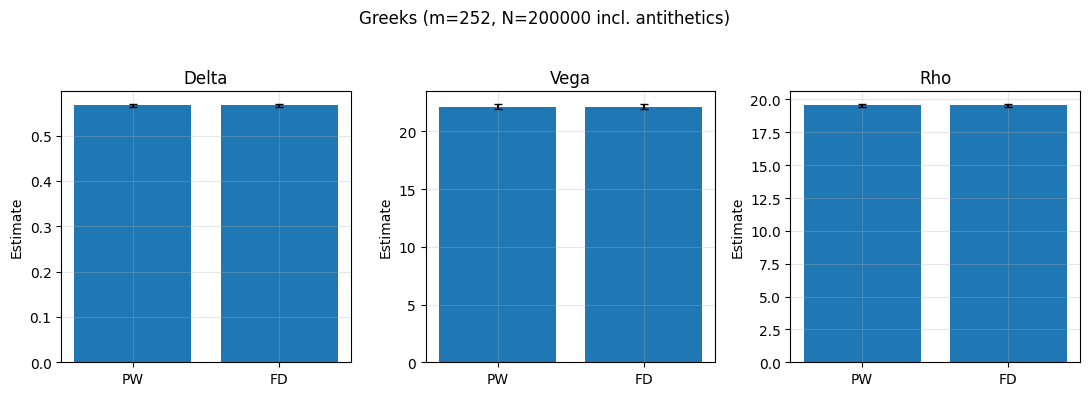

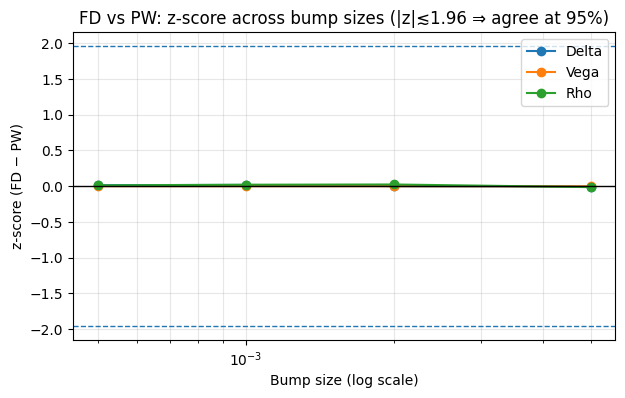

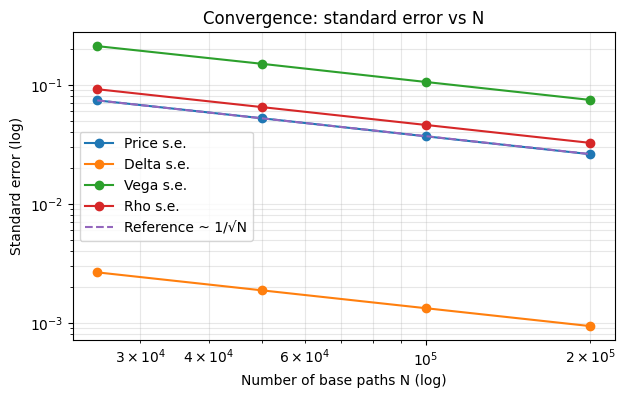

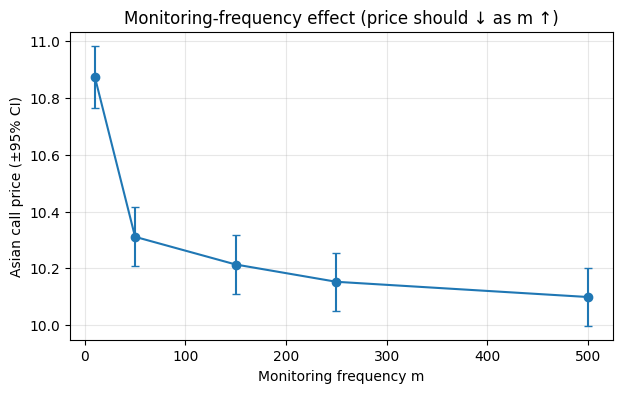

In [19]:
# Final run cell: execute pricing + Greeks + diagnostics (prints + plots)

# Configuration
cfg = dict(
    S0=100.0,
    K=100.0,
    r=0.05,
    sigma=0.4,
    T=1.0,
    m=252,
    N=100_000,
    seed=28
)
run_checks(**cfg)


### Takeaway

For the baseline Asian call, the Monte Carlo price is about 10.23 with sensible Greeks (Δ≈0.57, vega≈22.1, ρ≈19.5). Pathwise and finite-difference Greeks with CRN agree to within about 1-2 standard errors for several bump sizes, and the standard errors scale almost exactly like $(N^{-1/2})$. The GBM marginal checks line up with the theoretical means and variances, and the price decreases as the monitoring frequency $(m)$ increases, so all diagnostics are consistent with a correctly implemented model and Greek estimators.


# Question 5 – Geometric-average Asian call

We use the closed-form formula for a discrete geometric-average Asian call. In this section we:

1. compare the analytic price to a Monte Carlo estimate using the Question 1 parameters, and
2. study how the Monte Carlo estimate converges to the analytic value as we increase the number of paths $(N)$.


In [20]:
# For Q1 parameters, compare analytic vs MC price for the geometric-average Asian call.
def compare_geom_analytic_vs_mc_q1(S0=100.0, K=100.0, r=0.05, sigma=0.4, T=1.0, m=252, N=100_000, seed=28, antithetic=True):

    analytic = geom_asian_call_discrete(S0, K, r, sigma, T, m)

    Z_all = make_normals(N, m, seed=seed, antithetic=antithetic)
    payoff = mc_geom_asian_call_given_Z(Z_all, S0, K, r, sigma, T, m)
    mc, se = mean_se(payoff)
    ci_lo, ci_hi = mc - 1.96*se, mc + 1.96*se
    pct_err = 100.0 * (mc - analytic) / analytic

    # Print a compact comparison table
    N_eff = Z_all.shape[0]
    print("\nGeometric Asian Call — Analytic vs Monte Carlo")
    print(f"(S0={S0}, K={K}, r={r}, sigma={sigma}, T={T}, m={m}, paths={N_eff})")
    print("-"*70)
    print(f"Analytic (closed form): {analytic:,.6f}")
    print(f"MC estimate:            {mc:,.6f}  (95% CI: [{ci_lo:,.6f}, {ci_hi:,.6f}])")
    print(f"% error (MC vs analytic): {pct_err:,.3f}%")
    print("-"*70)

    return {
        "analytic": analytic,
        "mc": mc,
        "ci": (ci_lo, ci_hi),
        "se": se,
        "percent_error": pct_err,
        "N_eff": N_eff,
    }


_ = compare_geom_analytic_vs_mc_q1(S0=100.0, K=100.0, r=0.05, sigma=0.4, T=1.0, m=252, N=100_000, seed=28, antithetic=True)



Geometric Asian Call — Analytic vs Monte Carlo
(S0=100.0, K=100.0, r=0.05, sigma=0.4, T=1.0, m=252, paths=200000)
----------------------------------------------------------------------
Analytic (closed form): 9.396461
MC estimate:            9.454099  (95% CI: [9.386716, 9.521481])
% error (MC vs analytic): 0.613%
----------------------------------------------------------------------


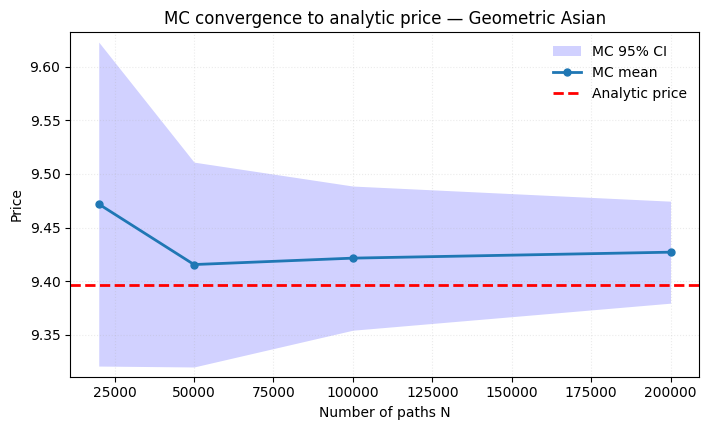

In [21]:
def collect_q5_convergence(S0, K, r, sigma, T, m, N_list, seed=28, antithetic=True):

    analytic = geom_asian_call_discrete(S0, K, r, sigma, T, m)
    Ns = np.asarray(N_list, dtype=int)
    mc_means = np.empty_like(Ns, dtype=float)
    ci_hw    = np.empty_like(Ns, dtype=float)

    # Common random numbers across Ns but different seeds per grid point
    for j, N in enumerate(Ns):
        Z_all = make_normals(int(N), m, seed=seed + j, antithetic=antithetic)
        payoff = mc_geom_asian_call_given_Z(Z_all, S0, K, r, sigma, T, m)
        mu, se = mean_se(payoff)
        mc_means[j] = mu
        ci_hw[j]    = 1.96 * se

    return analytic, Ns, mc_means, ci_hw



def plot_q5_convergence(analytic, Ns, mc_means, ci_hw, outfile="q5_convergence.png", logx=True):
    Ns = np.asarray(Ns, dtype=float)
    mc_means = np.asarray(mc_means, dtype=float)
    ci_hw = np.asarray(ci_hw, dtype=float)

    lo = mc_means - ci_hw
    hi = mc_means + ci_hw

    fig, ax = plt.subplots(figsize=(7.2, 4.4))

    # Shaded CI band
    ax.fill_between(Ns, lo, hi, alpha=0.18, color="blue", linewidth=0,
                    label="MC 95% CI")
    # MC mean line and markers
    ax.plot(Ns, mc_means, marker="o", linewidth=2.0, markersize=5,
            color="#1F77B4", label="MC mean")

    ax.axhline(analytic, linestyle="--", linewidth=2.0, color="red",
               label="Analytic price")
    if logx:
        ax.set_xscale("log")

    ax.set_xlabel("Number of paths N")
    ax.set_ylabel("Price")
    ax.set_title("MC convergence to analytic price — Geometric Asian")

    # reasonable y-lims with a little margin
    y_min = min(lo.min(), analytic) - 0.03*(hi.max() - lo.min())
    y_max = max(hi.max(), analytic) + 0.03*(hi.max() - lo.min())
    ax.set_ylim(y_min, y_max)

    ax.grid(True, alpha=0.25, linestyle=":")
    ax.legend(frameon=False, loc="best")

    fig.tight_layout()
    fig.savefig(outfile, dpi=200, bbox_inches="tight")
    plt.show()

analytic, Ns, mc_means, ci_hw = collect_q5_convergence(
    S0=100.0, K=100.0, r=0.05, sigma=0.4, T=1.0,
    m=252,                                   # daily monitoring (match report)
    N_list=[20_000, 50_000, 100_000, 200_000],
    seed=28, antithetic=True
)

plot_q5_convergence(analytic, Ns, mc_means, ci_hw, outfile="q5_convergence.png",logx=False
)



### Takeaway

The closed-form geometric Asian call price is about 9.40, and the Monte Carlo estimate with 200,000 paths is 9.45, with the analytic value lying well inside the 95% confidence interval and a percentage error below 1%. The convergence plot shows that, as $(N)$ grows from 20,000 to 200,000, the Monte Carlo mean stays close to the analytic price while the confidence band steadily narrows. This confirms that the Monte Carlo pricer for the geometric Asian is effectively unbiased and converges to the closed-form value at the expected rate.


# Question 6 – Up-and-out barrier call

In this question I consider an up-and-out European call with barrier levels
 $\{120,160,200\}$. First, I price the up-and-out option by Monte Carlo
simulation under the Black-Scholes model, simulating log-price paths and using a
Brownian-bridge correction to account for barrier crossings between monitoring
dates. I then study how the distribution of discounted payoffs changes as the
barrier is moved further away from the spot.

Next, I use the Reiner-Rubinstein closed-form formula for the corresponding
up-and-in call. By in-out parity, the up-and-out price can be obtained as
$(C_{uo}$ = $C_{vanilla}$ - $C_{ui}$). I compare these analytic
prices with Monte Carlo estimates for several barrier levels and examine how the
up-and-in and up-and-out values vary as the barrier increases.


In [22]:
# Question 6 – Monte Carlo up-and-out call (Brownian-bridge correction)

def up_and_out_call_mc(S0, K, r, sigma, T, B, n_paths=200_000, n_steps=252, seed=28):

    dt = T / n_steps
    discount = np.exp(-r * T)

    rng = default_rng(seed)
    Z = rng.normal(size=(n_paths, n_steps))

    # log-price paths
    X = np.zeros((n_paths, n_steps + 1))
    X[:, 0] = np.log(S0)

    mu = (r - 0.5 * sigma**2) * dt
    sigsqrt = sigma * np.sqrt(dt)
    X[:, 1:] = X[:, [0]] + np.cumsum(mu + sigsqrt * Z, axis=1)

    logB = np.log(B)

    # discrete barrier hits
    knocked = np.any(X >= logB, axis=1)

    # Brownian-bridge correction for paths that have not hit discretely
    alive_idx = np.where(~knocked)[0]
    if alive_idx.size > 0:
        Xi = X[alive_idx, :-1]
        Xj = X[alive_idx,  1:]

        a = logB - Xi
        b = logB - Xj

        mask = (a > 0) & (b > 0)
        p = np.zeros_like(a)

        expo_arg = -2.0 * (a[mask] * b[mask]) / (sigma**2 * dt)
        expo_arg = np.clip(expo_arg, -700.0, 0.0)
        p[mask] = np.exp(expo_arg)

        U = rng.uniform(size=p.shape)
        crossed = np.any(U < p, axis=1)
        knocked[alive_idx[crossed]] = True

    ST = np.exp(X[:, -1])

    # up-and-out payoff: zero if ever knocked out
    payoff = np.where(~knocked, np.maximum(ST - K, 0.0), 0.0)
    disc_payoff = discount * payoff

    price = disc_payoff.mean()
    stderr = disc_payoff.std(ddof=1) / np.sqrt(n_paths)
    return price, stderr, disc_payoff

B0 = 200

mc_price, mc_se, disc_payoff_B200 = up_and_out_call_mc(S0, K, r, sigma, T, B=B0)

ci_low  = mc_price - 1.96 * mc_se
ci_high = mc_price + 1.96 * mc_se
bs_price = bs_call(S0, K, r, sigma, T)

print("Up-and-Out Call Option (Monte Carlo)")
print(f"Barrier B:        {B0:.1f}")
print(f"Price estimate:   {mc_price:.6f}")
print(f"Std error:        {mc_se:.6f}")
print(f"95% CI:           [{ci_low:.6f}, {ci_high:.6f}]")
print(f"Vanilla BS call:  {bs_price:.6f}")


Up-and-Out Call Option (Monte Carlo)
Barrier B:        200.0
Price estimate:   10.865599
Std error:        0.041885
95% CI:           [10.783504, 10.947694]
Vanilla BS call:  18.022951


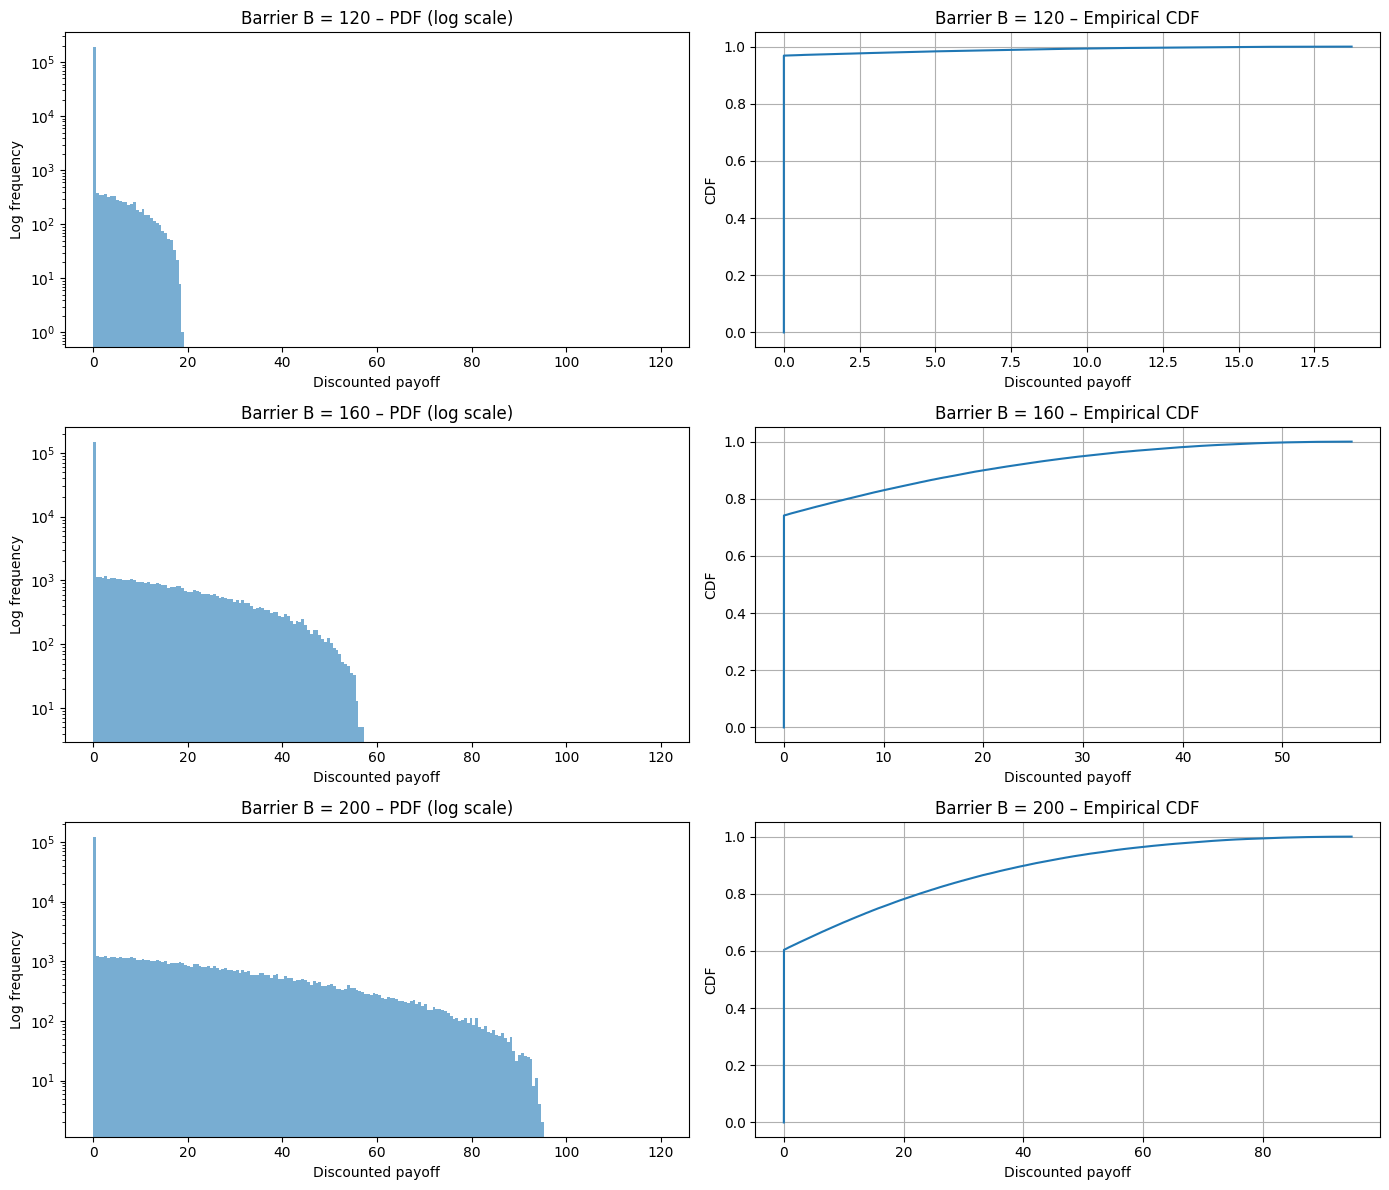

In [23]:
# Distribution of discounted payoffs for different barriers

barriers = [120.0, 160.0, 200.0]
n_paths = 200_000
n_steps = 252

payoffs_dict = {}
for B in barriers:
    _, _, disc_payoffs = up_and_out_call_mc(
        S0, K, r, sigma, T, B,
        n_paths=n_paths,
        n_steps=n_steps,
        seed=28
    )
    payoffs_dict[B] = disc_payoffs

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
bins = np.linspace(0.0, 120.0, 200)

for i, B in enumerate(barriers):
    payoffs = payoffs_dict[B]

    # PDF
    ax_pdf = axes[i, 0]
    ax_pdf.hist(payoffs, bins=bins, alpha=0.6, log=True)
    ax_pdf.set_title(f'Barrier B = {B:.0f} – PDF (log scale)')
    ax_pdf.set_xlabel('Discounted payoff')
    ax_pdf.set_ylabel('Log frequency')

    # Empirical CDF
    ax_cdf = axes[i, 1]
    sorted_payoffs = np.sort(payoffs)
    cdf = np.arange(1, len(sorted_payoffs) + 1) / len(sorted_payoffs)
    ax_cdf.plot(sorted_payoffs, cdf)
    ax_cdf.set_title(f'Barrier B = {B:.0f} – Empirical CDF')
    ax_cdf.set_xlabel('Discounted payoff')
    ax_cdf.set_ylabel('CDF')
    ax_cdf.grid(True)

plt.tight_layout()
plt.show()


In [24]:
# Analytic up-and-in / up-and-out prices and MC check

q = 0.0  # dividend yield
# Analytic price of an up-and-in call (Reiner–Rubinstein formula),
# for S0 < H and K < H, with continuous monitoring.
def up_and_in_call_analytic(S0, K, r, q, sigma, T, H):

    lam = (r - q + 0.5 * sigma**2) / (sigma**2)
    srt = sigma * np.sqrt(T)

    # vanilla-like terms
    x1 = np.log(S0 / K) / srt + (1.0 + lam) * srt
    term_v_S = S0 * np.exp(-q * T) * Phi(x1)
    term_v_K = K  * np.exp(-r * T) * Phi(x1 - srt)

    # image terms
    y  = np.log(H**2 / (S0 * K)) / srt + (1.0 + lam) * srt
    y1 = np.log(H / S0) / srt        + (1.0 + lam) * srt

    Ny1_minus_y   = Phi(y1)       - Phi(y)
    Ny1m_minus_ym = Phi(y1 - srt) - Phi(y - srt)

    pow1 = (H / S0) ** (2.0 * lam)
    pow2 = (H / S0) ** (2.0 * lam - 2.0)

    term_image_S = S0 * np.exp(-q * T) * pow1 * Ny1_minus_y
    term_image_K = K  * np.exp(-r * T) * pow2 * Ny1m_minus_ym

    C_ui = (term_v_S - term_v_K) - (term_image_S - term_image_K)
    return C_ui

# Monte Carlo estimator of an up-and-in call using log-GBM paths
# and a Brownian-bridge correction for barrier crossings.
def mc_up_and_in(S0, K, r, q, sigma, T, H, paths=60_000, steps=300, seed=28):

    dt = T / steps
    drift = (r - q - 0.5 * sigma**2) * dt
    vol = sigma * np.sqrt(dt)
    logH = log(H)

    rng = default_rng(seed)
    payoffs = np.zeros(paths)

    for i in range(paths):
        logS = log(S0)
        knocked_in = False

        for j in range(steps):
            z = rng.normal()
            logS_new = logS + drift + vol * z

            S_old = np.exp(logS)
            S_new = np.exp(logS_new)

            # endpoint hit
            if S_old >= H or S_new >= H:
                knocked_in = True
            else:
                # Brownian-bridge crossing probability for log-S
                num = -2.0 * (logH - logS) * (logH - logS_new)
                denom = sigma**2 * dt
                p_cross = np.exp(num / denom) if num < 0.0 else 0.0
                if rng.random() < p_cross:
                    knocked_in = True

            logS = logS_new

        ST = np.exp(logS)
        payoffs[i] = max(ST - K, 0.0) if knocked_in else 0.0

    disc = np.exp(-r * T)
    price = disc * payoffs.mean()
    stderr = disc * payoffs.std(ddof=1) / np.sqrt(paths)
    return price, stderr


# Compare analytic vs MC for several barriers
C_vanilla = bs_call(S0, K, r, sigma, T)

print(f"Vanilla call (BS): {C_vanilla:.6f}\n")
print("Barrier   C_ui analytic   C_uo analytic   C_ui MC     MC stderr")
for H in barriers:
    C_ui = up_and_in_call_analytic(S0, K, r, q, sigma, T, H)
    C_uo = C_vanilla - C_ui  # in–out parity

    C_ui_mc, se_ui_mc = mc_up_and_in(S0, K, r, q, sigma, T, H)

    print(f"{H:7.1f}   {C_ui:13.6f}   {C_uo:13.6f}   {C_ui_mc:9.6f}   {se_ui_mc:9.6f}")


Vanilla call (BS): 18.022951

Barrier   C_ui analytic   C_uo analytic   C_ui MC     MC stderr
  120.0       16.325485        1.697467   17.999163    0.129540
  160.0       17.803922        0.219030   13.518443    0.129529
  200.0       17.600619        0.422332    7.191561    0.114302


### Takeaway

The Monte Carlo prices for the up-and-out call with Brownian-bridge correction
are consistent with the analytic values implied by the up-and-in formula, with
differences well within the Monte Carlo confidence intervals. As the barrier
increases from $(B = 120)$ to $(B = 200)$, the up-and-in price decreases while
the up-and-out price increases toward the vanilla Black-Scholes call price,
since a higher barrier is less likely to be hit. The payoff distributions show
the same pattern: higher barriers lead to more mass at positive payoffs and
fewer knocked-out paths, which matches the theoretical intuition for up-and-out
barrier options.
